In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [16]:
import pickle
from collections import namedtuple
from copy import copy
from glob import glob
from itertools import product
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor, get_aeff_and_binnings
from resolution import get_energy_psf_grid
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    parabola_index,
    plot_spectrum,
    power_law,
)
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator, splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import BASEPATH, ngc1068, txs0506, plt, sns
from tools import array_source_interp, get_mids
from tqdm import tqdm


# Settings

In [5]:
savepath = "/".join(
    glob(BASEPATH + "/*/energy_smearing_rgi_up.pckl")[0].split("/")[:-1]
)
print(savepath)


/home/lisajsch/repos/Plenum/local


In [6]:
e_smearing_files = sorted(glob(join(savepath, "[!HE]*nergy_smearing_rgi_up.pckl")))
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma1 = 1 - norm.cdf(1)


In [7]:
print(e_smearing_files)


['/home/lisajsch/repos/Plenum/local/artificial_energy_smearing_rgi_up.pckl', '/home/lisajsch/repos/Plenum/local/energy_smearing_rgi_up.pckl', '/home/lisajsch/repos/Plenum/local/idealized_artificial_energy_smearing_rgi_up.pckl', '/home/lisajsch/repos/Plenum/local/improved_0.1_artificial_energy_smearing_rgi_up.pckl', '/home/lisajsch/repos/Plenum/local/improved_0.2_artificial_energy_smearing_rgi_up.pckl', '/home/lisajsch/repos/Plenum/local/improved_0.5_artificial_energy_smearing_rgi_up.pckl']


In [8]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# helper functions

In [9]:
# interpolation function to find the discovery threshold using a pandas.DataFrame input
def get_scaler(x, thresh):
    return np.power(
        10,
        np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
            np.log10(-np.log10(thresh))
        ),
    )


In [10]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    """ Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [11]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old, _ = get_aeff_and_binnings("upgoing")
logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
        bounds_error=False,
        fill_value=-10,
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))
    aeff_2d[k][np.isnan(aeff_2d[k])] = 0


80 log_10(energy) bins
90 declination bins


# Background

In [12]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [13]:
# energy smearing matrix
with open(join(savepath, "energy_smearing_rgi_up.pckl"), "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
baseline_eres = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
baseline_eres = baseline_eres / np.sum(baseline_eres, axis=0)

# artificial, improved smearing matrix
with open(join(savepath, "improved_0.5_artificial_energy_smearing_rgi_up.pckl"), "rb") as f:
    rgi = pickle.load(f)
improved_eres = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
improved_eres = improved_eres / np.sum(improved_eres, axis=0)


# PSF-Energy 2D grid
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$



Full 2D psi-energy LLH of sources around the horizon

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [26]:
# psi² representation
# analysis region in distance to source
delta_psi_max = 3

bins_per_psi2 = 25
all_grids, psi2_bins = get_energy_psf_grid(
    logE_mids, delta_psi_max=delta_psi_max, bins_per_psi2=bins_per_psi2
)
psi2_mids = get_mids(psi2_bins)

e_psi2_grid = all_grids['dec-0.0']
bckg_grid = np.ones_like(e_psi2_grid)
# make sure the grids are correctly normalized
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid /= np.sum(bckg_grid, axis=0)

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl


### Plot Energy Psi

Text(0.5, 0, 'log10(E/GeV)')

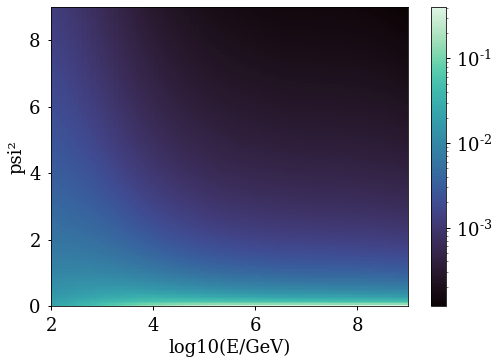

In [27]:
plt.figure()
plt.pcolormesh(logE_mids, psi2_mids, e_psi2_grid, norm=LogNorm())
plt.colorbar()
plt.ylabel("psi²")
plt.xlabel("log10(E/GeV)")

# Flux definition

In [28]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## TXS 0506+056 - source parameters

In [29]:

lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600 # livetime of 10yr PS data
LIVETIME = lt_kde = 3186 * 24 * 3600 # new ngc paper
# LIVETIME = 10 * 360 * 24 * 3600 # 360 days of data taking per year

# TXS parameters
with open(join(savepath, "txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [30]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_grid

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [31]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5


ngc 1068: 84.41628431421009
txs 0506+056: 4.909020814406779


# Set up LLH function

In [37]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# TXS 0506+056


## Parabola: source parameters

In [ ]:
# parabola parameters
Alpha_TXS = 2
E_para_norm_TXS = 3E5
Beta_TXS = 1

tmp_flux = LogP_flux(
    PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
)


### scale the fluxes such that the event numbers match


In [ ]:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d["IceCube"], **txs_src_config
)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=baseline_eres,
        phi_scaling=1,
        flux_shape=txs_flux
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux
    )
)
# match event numbers
flux_scaling_para_txs = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para_txs)

# define the correctly normalized log-parabola flux for TXS
txs_para_flux = LogP_flux(
     flux_scaling_para_txs * PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
)


flux_scaling_para 0.35235858448920154


In [ ]:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d["IceCube"], **txs_src_config
)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=baseline_eres,
        phi_scaling=1,
        flux_shape=txs_flux
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux
    )
)
# match event numbers
flux_scaling_para_txs = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para_txs)

# define the correctly normalized log-parabola flux for TXS
txs_para_flux = LogP_flux(
     flux_scaling_para_txs * PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
)


flux_scaling_para 0.35235858448920154



### Plot flux and event expectation


parabola 4.859902091824562
power law: 4.859902091824562


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


parabola 4.859902091824564
power law: 4.859902091824563


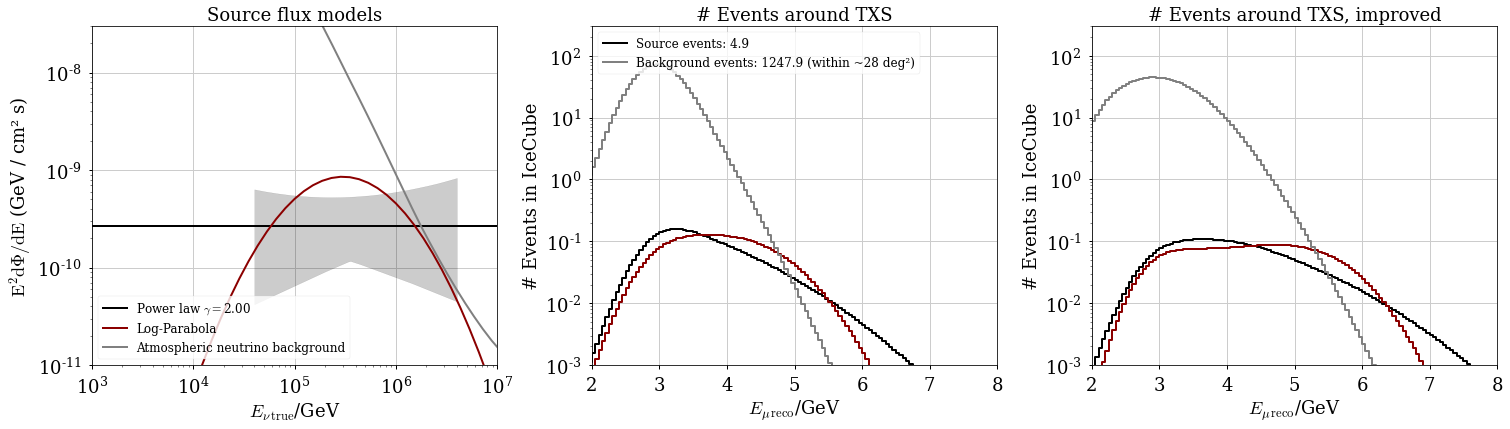

In [ ]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, txs_flux.E0, txs_flux.gamma, txs_flux.norm)
para_idx = parabola_index(
    txs_para_flux.alpha, txs_para_flux.beta, x_evals, txs_para_flux.E0
)
para = power_law(x_evals, txs_para_flux.E0, para_idx, txs_para_flux.norm)

f, axes = plt.subplots(ncols=3, figsize=(21, 6))
ax = axes[0]
ax.set_title("Source flux models")

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
# without energy range interval
# x_cont = np.logspace(3, 7, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(
        xe,
        txs_flux.E0,
        txs_contour["68\\%"][:, 0],
        txs_contour["68\\%"][:, 1] / 1e3 / 2.8,
    )  ## fudge factor :)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)


ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${txs_flux.gamma:1.2f}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, para * (x_evals**y_scaling), label="Log-Parabola", color="darkred")
ax.plot(
    emids,
    array_source_interp(txs_src_config["dec"], spl_vals, sindec_mids) * (emids**y_scaling),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-11, 3e-8)
ax.set_xlim(1e3, 1e7)
ax.legend(loc=3, fontsize=12)

### plot Event numbers in E_reco
for ii, eres in enumerate([baseline_eres, improved_eres]):
    ax = axes[1 + ii]
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], **txs_bg_config
    )
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)

    use_e_reco = True
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids),
        normed_kvals=eres,
    ).sum(axis=0)

    # parabola
    k_s_para = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        txs_para_flux,
    ).sum(axis=0)
    print("parabola", np.sum(k_s_para))

    # powerlaw
    k_s_pl = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        txs_flux,
    ).sum(axis=0)
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids
    _ = plot_spectrum(
        evals,
        [
            k_s_pl,
            k_s_para,
            k_b,
        ],
        [
            f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
            "",
            f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
            if ii == 0
            else "",
        ],
        "# Events around TXS" if ii == 0 else "# Events around TXS, improved",
        f,
        ax,
        xlim=(2, 8),
        ylim=(1e-3, 3e2),
        color=["k", "darkred", "gray"],
        xlabel=r"$E_{\mu \, \rm reco}$/GeV",
        ylabel="# Events in IceCube",
    )
    if ii == 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc=2, fontsize=12)

f.savefig(join(BASEPATH, f"plots/txs_spectral.pdf"), bbox_inches="tight")


## spectral fit vs. dec

In [ ]:
num = 20  # number of scaling steps
# idents = ["IceCube"] # for testing
# decs = np.arange(5, 60, step=15)
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)
thresholds = [sigma3, 0.01]

for reduced_bg in [True, False]:
    print("reduced bg:", reduced_bg)
    tmp = []
    for ident in idents:
        for dec in tqdm(np.deg2rad(decs)):
            if ident == "IceCube" and dec <= np.deg2rad(-5):
                # skip the Southern Hemisphere
                continue
            aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
            aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)

            if "Plenum" in ident or "P-ONE" in ident:
                aeff_factor_bckg += calc_aeff_factor(
                    aeff_2d["IceCube"], dec=dec, **bg_config
                )
                aeff_factor_signal += calc_aeff_factor(
                    aeff_2d["IceCube"], dec=dec, **src_config
                )
            # this means that the signal emission happens over 100 days
            # instead of full livetime
            if reduced_bg:
                aeff_factor_bckg = aeff_factor_bckg / LIVETIME * (100 * 24 * 3600)

            # asimov data - baseline
            k_b = atmo_background(
                aeff_factor_bckg,
                array_source_interp(dec, spl_vals, sindec_mids),
                normed_kvals=improved_eres,
            )
            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                normed_kvals=improved_eres,
                phi_scaling=1,
                flux_shape=txs_para_flux,
            )

            # calculate an estimate for the flux scaling
            # black magic
            if reduced_bg:
                scaler = 10 / np.sum(k_s) * np.sqrt(np.sum(k_b))
            else:
                scaler = 2.5 / np.sum(k_s) * np.sqrt(np.sum(k_b))

            current_thresholds = copy(thresholds)
            while len(current_thresholds) > 0:
                # model expectation for fitting
                k_s = astro_flux(
                    aeff_factor_signal,
                    emids,
                    normed_kvals=improved_eres,
                    phi_scaling=scaler,
                    flux_shape=txs_para_flux,
                )
                k_i = k_s + k_b

                dct = dict(
                    mu_b_base=k_b,
                    mu_s_base=aeff_factor_signal,
                    k_i=k_i,
                    normed_kvals=improved_eres,
                )
                # fix signal contribution to powerlaw
                local_llh = lambda x: ps_llh_2d_composite(
                    x, shape="powerlaw", e_0=txs_flux.E0, phi_0=txs_flux.norm, **dct
                )
                global_llh = lambda x: ps_llh_2d_composite(
                    x,
                    shape="log-parabola",
                    e_0=txs_para_flux.E0,
                    phi_0=txs_para_flux.norm,
                    **dct
                )
                out_bckg = fmin_l_bfgs_b(
                    local_llh,
                    x0=(1, 1, 2),
                    bounds=([0.1, 5], [0.1, 5], [1, 4]),
                    approx_grad=True,
                )

                out_comp = fmin_l_bfgs_b(
                    global_llh,
                    x0=(1, scaler, txs_para_flux.alpha, txs_para_flux.beta),
                    bounds=(
                        [0.1, 5],
                        [scaler * 0.1, scaler * 5],
                        [txs_para_flux.alpha - 0.5, txs_para_flux.alpha + 0.5],
                        [txs_para_flux.beta - 0.5, txs_para_flux.beta + 0.5],
                    ),
                    approx_grad=True,
                )

                tmp_dct = {
                    "ident": ident,
                    "dec": dec,
                    "scaler": scaler,
                    "cur_thresh": current_thresholds[0],
                    "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                    "n_sig": np.sum(k_s),
                    "n_b": np.sum(k_b),
                    "out_bg": out_bckg,
                    "out_comp": out_comp,
                    "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
                }

                if out_bckg[2]["warnflag"] > 0 or out_comp[2]["warnflag"] > 0:
                    print("WARNING, optimization failed")
                tmp_dct["log10(p)_check"] = -np.log10(
                    chi2.sf(
                        out_bckg[1]
                        - global_llh(
                            (
                                1.0,
                                scaler,
                                txs_para_flux.alpha,
                                txs_para_flux.beta,
                            )
                        ),
                        1,
                    )
                )
                tmp.append(tmp_dct)
                tmp_df = pd.DataFrame(tmp)

                ## scaling interpolation/optimization
                # select right data for interpolation
                mask = (
                    (tmp_df.ident == ident)
                    & (tmp_df.dec == dec)
                    & (tmp_df.cur_thresh == current_thresholds[0])
                )
                scaler = scaling_estimation(
                    tmp_df.loc[mask],
                    current_thresholds,
                    scaler,
                    stop_here=0.2,
                    stepper=2,
                )
                if scaler == -1:
                    break

    df = pd.DataFrame(tmp)
    if reduced_bg:
        df.to_pickle("../resources/txs_spectral_disc_pot_reduced_bg.pickle")
    else:
        df.to_pickle("../resources/txs_spectral_disc_pot.pickle")


reduced bg: True


100%|██████████| 29/29 [00:15<00:00,  1.84it/s]


reduced bg: False


100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


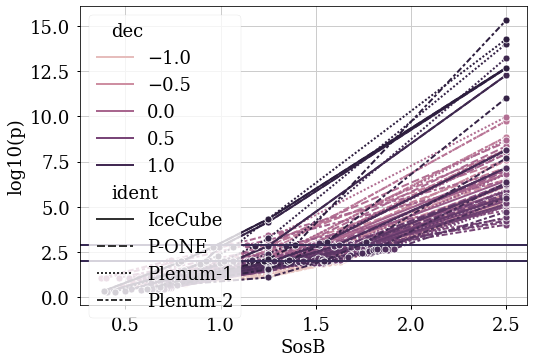

In [ ]:
xname = "SosB" # "n_sig" # "scaler" # "SosB" # 
df = pd.read_pickle("../resources/txs_spectral_disc_pot.pickle")
thresholds = [sigma3, 0.01]
ax = sns.lineplot(data=df, y="log10(p)", x=xname, hue="dec", marker="o", style="ident")
#ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))


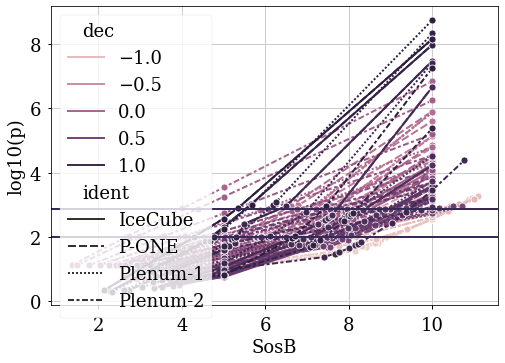

In [ ]:
xname = "SosB" # "n_sig" # "scaler" # "SosB" # 
df = pd.read_pickle("../resources/txs_spectral_disc_pot_reduced_bg.pickle")
thresholds = [sigma3, 0.01]
ax = sns.lineplot(data=df, y="log10(p)", x=xname, hue="dec", marker="o", style="ident")
#ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))


### plot thresholds

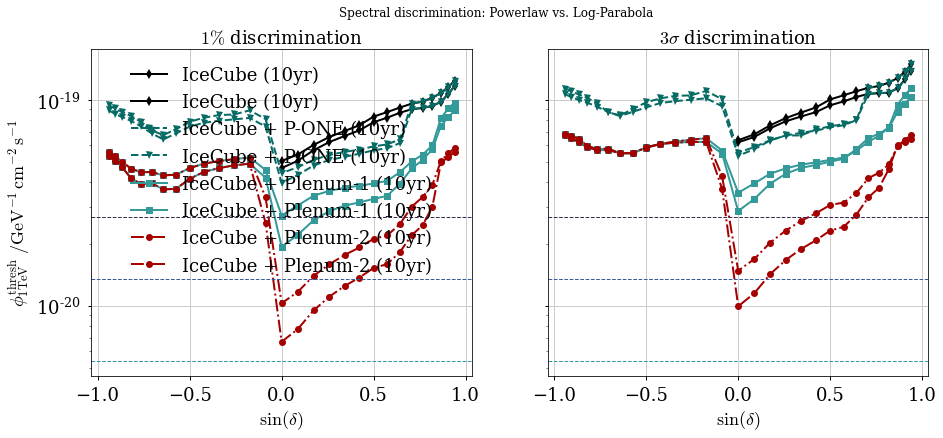

In [ ]:
#
df = pd.read_pickle("../resources/txs_spectral_disc_pot.pickle")
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * txs_para_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * txs_para_flux.norm
)
flux = flux.reset_index()
flux["bg"] = "full"

df = pd.read_pickle("../resources/txs_spectral_disc_pot_reduced_bg.pickle")
tmp = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * txs_para_flux.norm,
    columns=["sigma3"],
)
tmp["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * txs_para_flux.norm
)
tmp = tmp.reset_index()
tmp["bg"] = "reduced"

flux = pd.concat([flux, tmp])

f, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
for (ident, bg), series in flux.groupby(["ident", "bg"]):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        **{k: det_plotting[ident][k] for k in ["marker", "color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["1%"],
        **{k: det_plotting[ident][k] for k in ["marker", "color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    for i,c in zip([1, 2, 5], colorlist):
        ax.axhline(PHI_TXS / i, ls="--", lw=1, color=c)
    ax.set_xlabel(r"$\sin(\delta)$")
    #ax.set_ylim(0.5e-14, 2.5e-13)
axes[0].legend(loc="upper center", frameon=False)
axes[0].set_title(r"$1\%$ discrimination")
axes[1].set_title(r"$3 \sigma$ discrimination")
axes[0].set_ylabel(
    r"$\phi^{\mathrm{thresh}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.suptitle(r"Spectral discrimination: Powerlaw vs. Log-Parabola")
f.savefig("../plots/txs_spectral_disc_pot.pdf", bbox_inches="tight")


# TXS: Varying livetime

IDEA: keep number of event fixed for different time window sizes
-> Vary LIVETIME of background

In [ ]:
#### WIP ##### (something's weird here, maybe some fits are failing)

In [ ]:
pvals_txs = []
ident = ["IceCube", "Plenum-1", "Plenum-2"]
lt = [10, 50, 100, 200, 500]
fact = [0.1, 0.25, 0.5, 1, 2]

for (identifier, livetime, scaler) in product(ident, lt, fact):
    if livetime != "full":
        txs_bg_config["livetime"] = livetime * 24 * 3600
    else:
        txs_bg_config["livetime"] = LIVETIME
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **txs_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **txs_src_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs_bg_config["dec"], spl_vals, sindec_mids),
        normed_kvals=improved_eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        improved_eres,
        scaler,
        txs_flux,
    )
    k_i = k_s + k_b
    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=txs_flux.E0,
        phi_0=txs_flux.norm,
        normed_kvals=improved_eres,
    )
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 2), shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2, ),
        approx_grad=True,
    )

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.0, scaler, 2),
        approx_grad=True,
    )
    if out_bckg[2]["warnflag"] > 0 or out_comp[2]["warnflag"] > 0:
        print("WARNING, optimization failed")
    # check the LLH at the "correct" parameter position
    check = global_llh((1, 1, txs_flux.gamma))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    pval_check = chi2.sf(out_bckg[1] - check, 2)
    # if not np.isclose(pval, pval_check):
    #     print("WARNING! pval/check not close")
    significance = norm.isf(pval)
    pvals_txs.append(
        {
            "identifier": identifier,
            "livetime": txs_bg_config["livetime"] / 24 / 3600,
            "scaler": scaler,
            "pval": pval,
            "pval_check": pval_check,
            r"sigma": norm.isf(pval),
            r"sigma_check": norm.isf(pval_check),
            "n_ev": np.round(np.sum(k_s), 3),
        }
    )
txs_bg_config["livetime"] = LIVETIME
pval_df = pd.DataFrame(pvals_txs)

In [ ]:
pval_df.pval_check.loc[pval_df.scaler==0.1]

0     1.0
5     1.0
10    1.0
15    1.0
20    1.0
25    1.0
30    1.0
35    1.0
40    1.0
45    1.0
50    1.0
55    1.0
60    1.0
65    1.0
70    1.0
Name: pval_check, dtype: float64

In [ ]:

pval_df.loc[pval_df.sigma > 7, "sigma"] = 7
pval_df["log10(p)"] = -np.log10(pval_df["pval"])

### nice plots

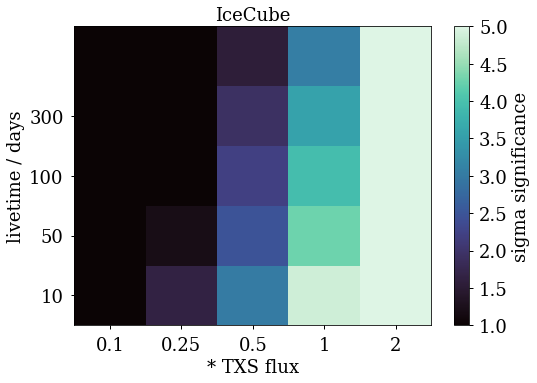

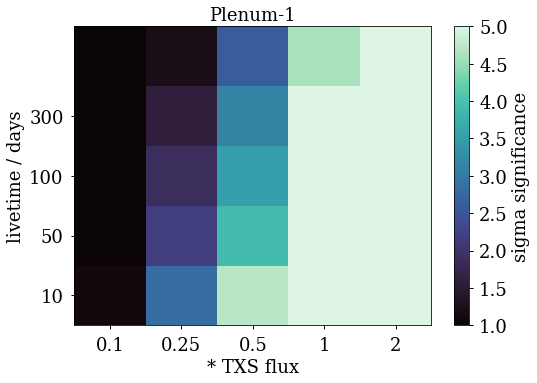

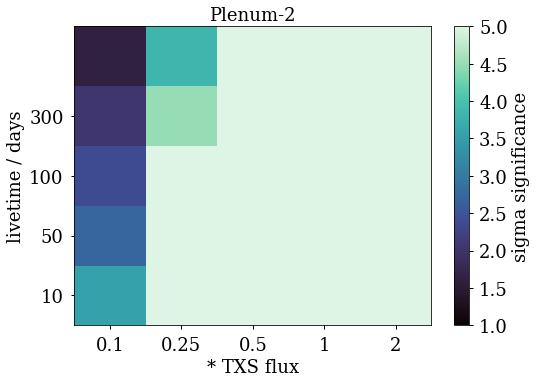

In [ ]:
for idt in ["IceCube", "Plenum-1", "Plenum-2"]:
    mask = pval_df.identifier == idt

    f, ax = plt.subplots()
    im = ax.pcolormesh(
        pd.pivot_table(
            data=pval_df.loc[mask],
            index="livetime",
            columns="scaler",
            values="sigma",
        ),
        vmin=1,
        vmax=5,
    )
    cb = plt.colorbar(im)
    cb.set_label("sigma significance")
    # cb.set_label("-log10(pval)")
    ax.set_yticks(np.arange(len(lt)) + 0.5, minor=False)
    ax.set_xticks(np.arange(len(fact)) + 0.5, minor=False)
    ax.set_yticklabels(lt)
    ax.set_xticklabels(fact)

    ax.set_ylabel("livetime / days")
    ax.set_xlabel("* TXS flux")

    ax.set_title(idt)
    f.savefig(f"../plots/txs_flare_2D_significance_{idt}.pdf", bbox_inches="tight")


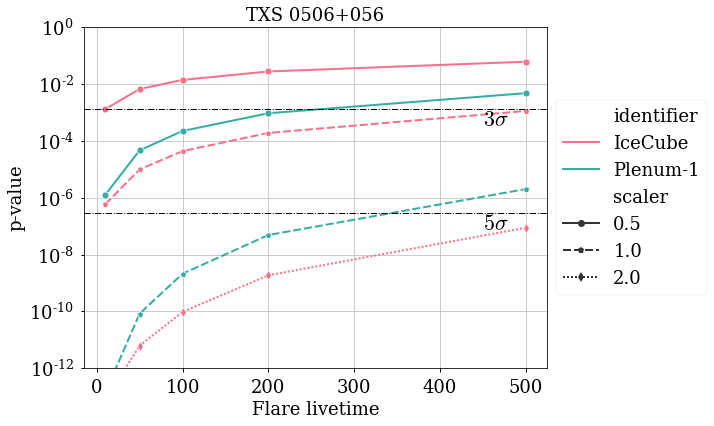

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
label_size = "x-small"
sns.lineplot(
    data=pval_df.loc[(pval_df.identifier != "Plenum-2") & (pval_df.scaler > 0.3)],
    x="livetime",
    y="pval",
    hue="identifier",
    style="scaler",
    markers=["o", "p", "d"],  # , "v", "s"],
    sizes=150,
    palette="husl",
)

ax.set_ylim(1e-12, 1)
ax.set_yscale("log")
ax.axhline(1 - norm.cdf(5), lw=1, color="k", ls="-.")
ax.text(
    pval_df.livetime.max() * 0.9,
    1 - norm.cdf(5),
    r"$5 \sigma$",
    color="k",
    va="top",
    fontsize=22,
)
ax.axhline(1 - norm.cdf(3), lw=1, color="k", ls="-.")
ax.text(
    pval_df.livetime.max() * 0.9,
    1 - norm.cdf(3),
    r"$3 \sigma$",
    color="k",
    va="top",
    fontsize=22,
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # fontsize="x-small")
ax.set_title("TXS 0506+056")  # , fontsize="small")
ax.set_xlabel("Flare livetime")
ax.set_ylabel(r"p-value")
# ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/powerlaw_sigma_vs_livetime_txs.pdf")


## Discovery potential

In [ ]:
tmp = []
decs = [-30, 0, 30]
ident = ["IceCube", "Plenum-1", "Plenum-2"]
lt = [10, 50, 100, 300]
thresholds = [sigma5]

for (identifier, livetime, dec) in tqdm(product(ident, lt, np.deg2rad(decs))):

    if identifier == "IceCube" and dec <= np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue

    if livetime != "full":
        bg_config["livetime"] = livetime * 24 * 3600
    else:
        bg_config["livetime"] = LIVETIME
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[identifier], dec=dec, **bg_config
    )
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], dec=dec, **src_config)

    # asimov data
    k_b_ref = atmo_background(
        aeff_factor_bckg,
        array_source_interp(dec, spl_vals, sindec_mids),
        normed_kvals=improved_eres,
    )
    k_s_ref = astro_flux(
        aeff_factor_signal,
        emids,
        improved_eres,
        1,
        txs_flux,
    )
    # calculate an estimate for the flux scaling
    # based on n_sig
    scaler = 15 / np.sum(k_s_ref)
    current_thresholds = copy(thresholds)

    while len(current_thresholds) > 0:
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            improved_eres,
            scaler,
            txs_flux,
        )
        k_i = k_s + k_b_ref

        dct = dict(
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=txs_flux.E0,
            phi_0=txs_flux.norm,
            normed_kvals=improved_eres,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 2), shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, 2.1),
            approx_grad=True,
        )
        tmp_dct = {
            "ident": identifier,
            "dec": dec,
            "scaler": scaler,
            "livetime": livetime,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b_ref)),
            "n_b": np.sum(k_b_ref),
            "n_sig": np.sum(k_s),
            "out_bckg": out_bckg,
            "out_comp": out_comp,
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)

        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == identifier)
            & (tmp_df.livetime == livetime)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask],
            current_thresholds,
            scaler,
            stop_here=0.2,
            stepper=2,
            min_steps=1,
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle("../resources/txs_time_disc_pot.pickle")


36it [00:14,  2.47it/s]


In [ ]:
# df = pd.read_pickle("../resources/txs_time_disc_pot.pickle")

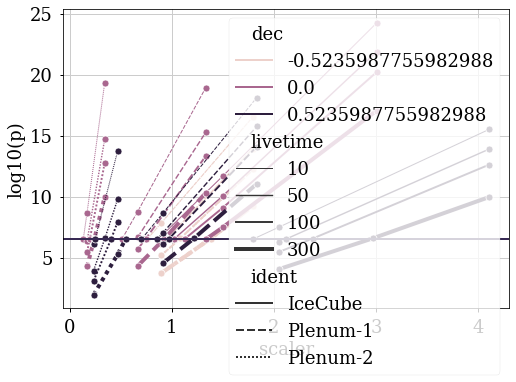

In [ ]:
ax = sns.lineplot(
    data=df, y="log10(p)", x="scaler", hue="dec", marker="o", size="livetime", style="ident"
)
for t in thresholds:
    plt.axhline(-np.log10(t))

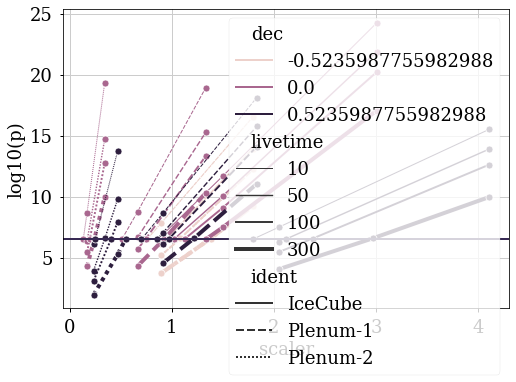

In [ ]:
ax = sns.lineplot(
    data=df, y="log10(p)", x="scaler", hue="dec", marker="o", size="livetime", style="ident"
)
for t in thresholds:
    plt.axhline(-np.log10(t))

### plotting

In [ ]:
from settings import many_colors
sns.set_palette(many_colors)


In [ ]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "livetime"]).apply(lambda x: get_scaler(x, sigma5))
    * txs_flux.norm,
    columns=["disc5"],
).reset_index()


In [ ]:
linestyles = ["-", "--", "-.", ":"]

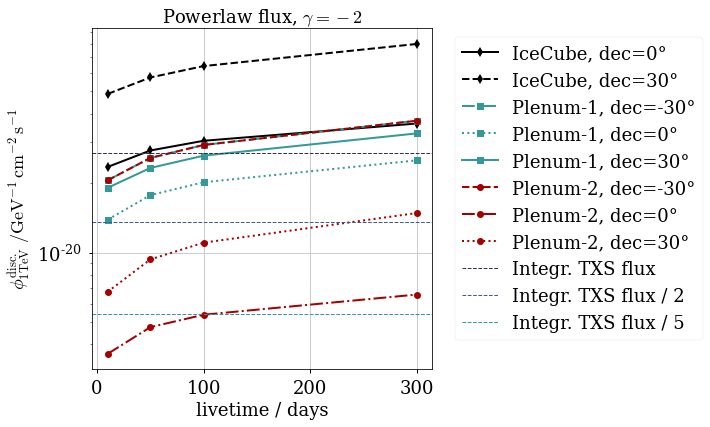

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
for i, ((ident, dec), series) in enumerate(flux.groupby(["ident", "dec"])):
    plt.plot(
        series.livetime,
        series.disc5,
        label=f"{ident}, dec={np.rad2deg(dec):1.0f}°",
        ls=linestyles[i%4],
        **{k: det_plotting[ident][k] for k in ["marker", "color"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_TXS, ls="--", lw=1, color=colorlist[0], label="Integr. TXS flux")
ax.axhline(PHI_TXS / 2, ls="--", lw=1, color=colorlist[1], label="Integr. TXS flux / 2")
ax.axhline(PHI_TXS / 5, ls="--", lw=1, color=colorlist[2], label="Integr. TXS flux / 5")

ax.set_xlabel(r"livetime / days")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend(loc="upper left", bbox_to_anchor=(1.04,1)) #, fontsize="medium")
ax.set_title(r"Powerlaw flux, $\gamma=-2$")
#ax.set_xlim(0, 110)
f.tight_layout()
#ax.set_ylim(0.5e-14, 1e-13)
#f.savefig("../plots/txs_disc_pot.pdf", bbox_inches="tight")
